In [2]:
path = 'lab8/'

import pandas as pd
import re
import nltk
import os
from nltk import CFG, BottomUpChartParser, BottomUpLeftCornerChartParser, LeftCornerChartParser
from nltk.metrics import jaccard_distance
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from scipy.stats import pearsonr
from IPython.display import display_html
import svgling
import contextlib

from nltk.parse.corenlp import CoreNLPDependencyParser



# Lab 8: Parsing

For the eighth practical of the subject, the goal is to try some non-probabilistic parsers, and optionally probabilistic parsers as well. The **mandatory** statement is:

1. Consider the following sentence:
`Lazy cats play with mice.`
2. Expand the grammar of the example related to non-probabilistic chart parsers in order to subsume this new sentence.
3. Perform the constituency parsing using a BottomUpChartParser, a BottomUpLeftCornerChartParser and a LeftCornerChartParser.
4. For each one of them, provide the resulting tree, the number of edges and the list of explored edges.
5. Which parser is the most efficient for parsing the sentence?
6. Which edges are filtered out by each parser and why?

The **optional** statement, which we've also accomplished, is:

1. Read all pairs of sentences of the SMTeuroparl files of test set within the evaluation framework of the project.
2. Compute the Jaccard similarity of each pair using the dependency triples from CoreNLPDependencyParser.
3. Show the results. Do you think it could be relevant to use NEs to compute the similarity between two sentences? Justify the answer.

## Mandatory exercise: Non-probabilistic parsers

We add the words `"Lazy"` (adjective, `JJ`), `"play"` (verb, `V`) and `"with"` (preposition, `PP`) in order to expand the grammar given so it satisfies the sentence `Lazy cats play with mice`. Moreover, since you said to use the smallest possible grammar, we have removed some of the stuff that was previously present. We could even make it smaller by putting the exact appearance of each element to subsum, however, this causes the Bottom-Up Left-Corner and the Left-Corner parser to produce the same edges. Hence, we add a bit more "generalization" to see the differences between the parsers.

Reference: https://www.nltk.org/book/ch08.html

In [3]:
grammar = CFG.fromstring('''
  S   -> NP VP
  VP  -> V | V PP NP
  NP  ->  NNS | JJ NNS
  NNS -> "cats" | "mice" 
  PP  -> "with"
  V   -> "play"
  JJ  -> "Lazy"
  ''')
sent = ['Lazy', 'cats', 'play', 'with', 'mice']

In [17]:
results = pd.DataFrame(columns = ['Parser', 'Edges', 'Trees'])
def parsers(grammar, sent, parser_func):
    parser = getattr(nltk, parser_func)(grammar, trace=1)
    parse = parser.parse(sent)
    trees = [t for t in parse] # get the number of trees
    with open(os.devnull, "w") as f, contextlib.redirect_stdout(f): # avoid printing to stdout, its the same tree
        parse = parser.chart_parse(sent) # we use this to get number of edges, we could do it manually but eh
    print('-'*80)
    print('Number of trees:', len(trees))
    print('Number of edges:', parse.num_edges())
    print('-'*80)

    #[print(edge) for edge in parse.edges()] # this would get a list of edges, but its the same we already see in the original trace
    return parse.num_edges(), len(trees), trees[0] 

### BottomUpChartParser

|.  Lazy .  cats .  play .  with .  mice .|
|[-------]       .       .       .       .| [0:1] 'Lazy'
|.       [-------]       .       .       .| [1:2] 'cats'
|.       .       [-------]       .       .| [2:3] 'play'
|.       .       .       [-------]       .| [3:4] 'with'
|.       .       .       .       [-------]| [4:5] 'mice'
|>       .       .       .       .       .| [0:0] JJ -> * 'Lazy'
|[-------]       .       .       .       .| [0:1] JJ -> 'Lazy' *
|>       .       .       .       .       .| [0:0] NP -> * JJ NNS
|[------->       .       .       .       .| [0:1] NP -> JJ * NNS
|.       >       .       .       .       .| [1:1] NNS -> * 'cats'
|.       [-------]       .       .       .| [1:2] NNS -> 'cats' *
|.       >       .       .       .       .| [1:1] NP -> * NNS
|[---------------]       .       .       .| [0:2] NP -> JJ NNS *
|.       [-------]       .       .       .| [1:2] NP -> NNS *
|.       >       .       .       .       .| [1:1] S  -> * NP VP
|.       [------->       .

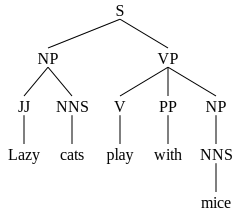

In [18]:
edges, trees, tree = parsers(grammar, sent, 'BottomUpChartParser')
results.loc[len(results)] = ['Bottom Up', edges, trees] 
svgling.draw_tree(tree)

### BottomUpLeftCornerChartParser

|.  Lazy .  cats .  play .  with .  mice .|
|[-------]       .       .       .       .| [0:1] 'Lazy'
|.       [-------]       .       .       .| [1:2] 'cats'
|.       .       [-------]       .       .| [2:3] 'play'
|.       .       .       [-------]       .| [3:4] 'with'
|.       .       .       .       [-------]| [4:5] 'mice'
|[-------]       .       .       .       .| [0:1] JJ -> 'Lazy' *
|[------->       .       .       .       .| [0:1] NP -> JJ * NNS
|.       [-------]       .       .       .| [1:2] NNS -> 'cats' *
|.       [-------]       .       .       .| [1:2] NP -> NNS *
|[---------------]       .       .       .| [0:2] NP -> JJ NNS *
|[--------------->       .       .       .| [0:2] S  -> NP * VP
|.       [------->       .       .       .| [1:2] S  -> NP * VP
|.       .       [-------]       .       .| [2:3] V  -> 'play' *
|.       .       [-------]       .       .| [2:3] VP -> V *
|.       .       [------->       .       .| [2:3] VP -> V * PP NP
|[-----------------------]   

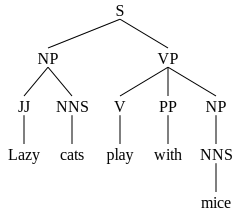

In [19]:
edges, trees, tree = parsers(grammar, sent, 'BottomUpLeftCornerChartParser')
results.loc[len(results)] = ['Bottom Up Left Corner', edges, trees] 
svgling.draw_tree(tree)

### LeftCornerChartParser

|.  Lazy .  cats .  play .  with .  mice .|
|[-------]       .       .       .       .| [0:1] 'Lazy'
|.       [-------]       .       .       .| [1:2] 'cats'
|.       .       [-------]       .       .| [2:3] 'play'
|.       .       .       [-------]       .| [3:4] 'with'
|.       .       .       .       [-------]| [4:5] 'mice'
|[-------]       .       .       .       .| [0:1] JJ -> 'Lazy' *
|[------->       .       .       .       .| [0:1] NP -> JJ * NNS
|.       [-------]       .       .       .| [1:2] NNS -> 'cats' *
|.       [-------]       .       .       .| [1:2] NP -> NNS *
|[---------------]       .       .       .| [0:2] NP -> JJ NNS *
|[--------------->       .       .       .| [0:2] S  -> NP * VP
|.       [------->       .       .       .| [1:2] S  -> NP * VP
|.       .       [-------]       .       .| [2:3] V  -> 'play' *
|.       .       [-------]       .       .| [2:3] VP -> V *
|.       .       [------->       .       .| [2:3] VP -> V * PP NP
|[-----------------------]   

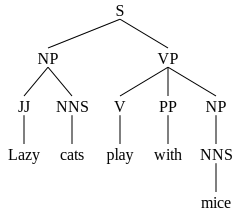

In [20]:
edges, trees, tree = parsers(grammar, sent, 'LeftCornerChartParser')
results.loc[len(results)] = ['Left Corner', edges, trees] 
svgling.draw_tree(tree)

### **Conclusions**


In [21]:
results

,Parser,Edges,Trees
0,Bottom Up,38,1
1,Bottom Up Left Corner,25,1
2,Left Corner,24,1


**Which parser is the most efficient for parsing the sentence?**

We have seen that all three parsers correctly subsume the sentence. The main difference, in this case, is in the number of edges the parser expands before returning a valid tree. The number of edges expanded/produced basically means the efficiency of the parser in returning the tree, where fewer edges means more efficiency, i.e. fewer edges produced to complete the parse.

We see in the summary table above, that the Bottom-Up parser returns the worst results with 38 edges expanded, while the Bottom-Up Left-Corner and the Left-Corner return almost identical results, with the Left-Corner (24 edges) beating the Bottom-Up Left-Corner (25 edges) by one edge.


**Which edges are filtered out by each parser, and why?**

- **Bottom-Up**: it takes the input string and tries to combine words to constituents and constituents to bigger constituents using the grammar rules from right to left. In doing so, any constituent that can be built is built; no matter whether they fit into the constituent that we are working on at the moment or not. 

    Comparing the Bottom-Up parser with the other two parsers, we see that the Bottom-Up expanded the most edges. These "added" edges that appear always have the same form, they always have the `*` on the left of a constituent. Specifically, the following 13 edges have been produced:
    ```
    [0:0] JJ -> * 'Lazy'
    [0:0] NP -> * JJ NNS
    [1:1] NNS -> * 'cats'
    [1:1] NP -> * NNS
    [1:1] S  -> * NP VP
    [0:0] S  -> * NP VP
    [2:2] V  -> * 'play'
    [2:2] VP -> * V
    [2:2] VP -> * V PP NP
    [3:3] PP -> * 'with'
    [4:4] NNS -> * 'mice'
    [4:4] NP -> * NNS
    [4:4] S  -> * NP VP
    ```

Every edge is of the form $A \rightarrow {}^* B$ and these sorts of edges are filtered on the Bottom-Up Left-Corner and the Left-Corner parsers.

- **Bottom-up Left-Corner**: modifies a rule of the original Bottom-Up, such to license any edge corresponding to a production whose right-hand side begins with a complete edge's left-hand side. In particular, this rule specifies that $A \rightarrow \alpha {}^\ast$ licenses the edge $B \rightarrow  A^* \beta$ for each grammar production $B \rightarrow A \beta$. In other words, it filters the edges without any word subsumed. In even easier words, it only produces an edge if its left corner has already been found (the first element of the right-hand side).

Comparing Bottom-Up Left-Corner with Left-Corner, we can see that the Left-Corner does not have the following edge:

`[4:5] S  -> NP * VP`

- **Left-Corner**: alternates steps of bottom-up processing with top-down predictions. It imposes top-down constraints in what the following input string can be. It starts with top-down prediction fixing the category that is to be recognized and then takes a bottom-up step and alternates between the both until it is subsumed. This is in theory how they work, checking the NLTK implementation seems to follow a slightly different approach, where it basically follows the same approach as the Bottom-Up Left-Corner, but filters some edges following a bottom up approach. Specifically, it filters out edges without new word subsumptions, if we have $A\rightarrow \alpha$ and $B \rightarrow \beta$ then we filter $C \rightarrow A^* B$. Thus, in the Bottom-Up Left-Corner we had `S  -> NP * VP`, which is filtered since we have `NP -> NNS *` and `VP -> V PP * NP`. Additionally, the same 13 previous edges are also filtered from the Bottom-Up Parser.

## Optional exercise: Dependency parser

To use Stanford CoreNLP, we first need to download and run the CoreNLP server on `localhost:9000` by following the next few steps:

1. Download CoreNLP at https://stanfordnlp.github.io/CoreNLP/download.html
2. Unzip the files and run the following commands in the directory to start the server: 

```
cd stanford-corenlp-4.5.1/
java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -preload tokenize,ssplit,pos,lemma,ner,parse,depparse -status_port 9000 -port 9000 -timeout 15000 &
```

3. Run the following commands in the notebook, it might be that the jupyter notebook and the CoreNLP server are on the same port, make sure this does not happen.

In [22]:
parser = CoreNLPDependencyParser(url='http://localhost:9000/')

In [23]:
def apply_jaccard_distance(sentence1, sentence2):
    if len(sentence1.union(sentence2)) == 0: # if the union of elements is empty, we consider the similarity to be zero
        return 0
    else:
        return 5*(1 - jaccard_distance(sentence1, sentence2))

In [24]:
def data_reader(function_preprocess):
    dt = pd.read_csv(path + 'STS.input.SMTeuroparl.txt', sep='\t', header = None)
    dt[2] = dt.apply(lambda row: function_preprocess(row[0]), axis = 1)
    dt[3] = dt.apply(lambda row: function_preprocess(row[1]), axis = 1)
    dt['gs'] = pd.read_csv(path + 'STS.gs.SMTeuroparl.txt', sep='\t', header = None)
    dt['jac'] = dt.apply(lambda row: apply_jaccard_distance(row[2], row[3]), axis = 1)
    return dt

In [25]:
stopw = set(nltk.corpus.stopwords.words('english')) # english stopwords

def apply_CoreNLDPependencyParser(sentence):
    parse, = parser.raw_parse(sentence)
    triples = []
    for governor, dep, dependent in parse.triples():
        if dep == 'punct' or governor[0].lower() in stopw:
            continue
        triples.append(( (governor[0].lower(), governor[1]), dep, (dependent[0].lower(), dependent[1])))
    return set(triples)

In [26]:
dt = data_reader(apply_CoreNLDPependencyParser)

In [27]:
styler = dt.head(3).style.set_table_attributes("style='display:inline'")
display_html(styler._repr_html_(), raw=True)

,0,1,2,3,gs,jac
0,The leaders have now been given a new chance and let us hope they seize it.,The leaders benefit aujourd' hui of a new luck and let's let them therefore seize it.,"{(('given', 'VBN'), 'aux:pass', ('been', 'VBN')), (('chance', 'NN'), 'amod', ('new', 'JJ')), (('seize', 'VB'), 'obj', ('it', 'PRP')), (('hope', 'VB'), 'ccomp', ('seize', 'VB')), (('leaders', 'NNS'), 'det', ('the', 'DT')), (('chance', 'NN'), 'det', ('a', 'DT')), (('given', 'VBN'), 'obj', ('chance', 'NN')), (('given', 'VBN'), 'nsubj:pass', ('leaders', 'NNS')), (('given', 'VBN'), 'advmod', ('now', 'RB')), (('let', 'VB'), 'cc', ('and', 'CC')), (('let', 'VB'), 'ccomp', ('hope', 'VB')), (('hope', 'VB'), 'nsubj', ('us', 'PRP')), (('given', 'VBN'), 'conj', ('let', 'VB')), (('seize', 'VB'), 'nsubj', ('they', 'PRP')), (('given', 'VBN'), 'aux', ('have', 'VBP'))}","{(('seize', 'VB'), 'obj', ('it', 'PRP')), (('benefit', 'VBP'), 'conj', ('let', 'VB')), (('hui', 'NNP'), 'nmod', ('luck', 'NN')), (('leaders', 'NNS'), 'det', ('the', 'DT')), (('benefit', 'VBP'), 'obj', ('hui', 'NNP')), (('let', 'VB'), 'ccomp', ('let', 'VB')), (('benefit', 'VBP'), 'nsubj', ('leaders', 'NNS')), (('let', 'VB'), 'cc', ('and', 'CC')), (('let', 'VB'), 'ccomp', ('seize', 'VB')), (('seize', 'VB'), 'nsubj', ('them', 'PRP')), (('luck', 'NN'), 'case', ('of', 'IN')), (('let', 'VB'), 'nsubj', (""'s"", 'PRP')), (('luck', 'NN'), 'amod', ('new', 'JJ')), (('hui', 'NNP'), 'compound', ('aujourd', 'NN')), (('seize', 'VB'), 'advmod', ('therefore', 'RB')), (('luck', 'NN'), 'det', ('a', 'DT'))}",4.500000,0.535714
1,Amendment No 7 proposes certain changes in the references to paragraphs.,Amendment No 7 is proposing certain changes in the references to paragraphs.,"{(('7', 'NNP'), 'compound', ('no', 'NNP')), (('changes', 'NNS'), 'nmod', ('references', 'NNS')), (('references', 'NNS'), 'det', ('the', 'DT')), (('references', 'NNS'), 'nmod', ('paragraphs', 'NNS')), (('references', 'NNS'), 'case', ('in', 'IN')), (('proposes', 'VBZ'), 'obj', ('changes', 'NNS')), (('changes', 'NNS'), 'amod', ('certain', 'JJ')), (('paragraphs', 'NNS'), 'case', ('to', 'IN')), (('proposes', 'VBZ'), 'nsubj', ('7', 'NNP')), (('7', 'NNP'), 'compound', ('amendment', 'NNP'))}","{(('paragraphs', 'NNS'), 'case', ('to', 'IN')), (('7', 'NNP'), 'compound', ('no', 'NNP')), (('changes', 'NNS'), 'nmod', ('references', 'NNS')), (('references', 'NNS'), 'det', ('the', 'DT')), (('references', 'NNS'), 'nmod', ('paragraphs', 'NNS')), (('proposing', 'VBG'), 'nsubj', ('7', 'NNP')), (('references', 'NNS'), 'case', ('in', 'IN')), (('proposing', 'VBG'), 'aux', ('is', 'VBZ')), (('changes', 'NNS'), 'amod', ('certain', 'JJ')), (('proposing', 'VBG'), 'obj', ('changes', 'NNS')), (('7', 'NNP'), 'compound', ('amendment', 'NNP'))}",5.000000,3.076923
2,Let me remind you that our allies include fervent supporters of this tax.,"I would like to remind you that among our allies, there are strong of this tax.","{(('remind', 'VB'), 'ccomp', ('include', 'VBP')), (('supporters', 'NNS'), 'nmod', ('tax', 'NN')), (('include', 'VBP'), 'obj', ('supporters', 'NNS')), (('remind', 'VB'), 'nsubj', ('me', 'PRP')), (('include', 'VBP'), 'mark', ('that', 'IN')), (('supporters', 'NNS'), 'amod', ('fervent', 'JJ')), (('tax', 'NN'), 'case', ('of', 'IN')), (('tax', 'NN'), 'det', ('this', 'DT')), (('remind', 'VB'), 'obj', ('you', 'PRP')), (('include', 'VBP'), 'nsubj', ('allies', 'NNS')), (('allies', 'NNS'), 'nmod:poss', ('our', 'PRP$')), (('let', 'VB'), 'ccomp', ('remind', 'VB'))}","{(('strong', 'JJ'), 'obl', ('tax', 'NN')), (('like', 'VB'), 'nsubj', ('i', 'PRP')), (('allies', 'NNS'), 'case', ('among', 'IN')), (('like', 'VB'), 'aux', ('would', 'MD')), (('remind', 'VB'), 'ccomp', ('are', 'VBP')), (('remind', 'VB'), 'mark', ('to', 'TO')), (('tax', 'NN'), 'case', ('of', 'IN')), (('like', 'VB'), 'xcomp', ('remind', 'VB')), (('tax', 'NN'), 'det', ('this', 'DT')), (('remind', 'VB'), 'obj', ('you', 'PRP')), (('allies', 'NNS'), 'nmod:poss', ('our', 'PRP$'))}",4.250000,1.052632


In [32]:
dt['diff'] = abs(dt['jac'] - dt['gs'])
dt_worst = dt.sort_values(by=['diff'], ascending=False).head(2)
df1_styler = dt_worst.style.set_table_attributes("style='display:inline'").set_caption('Highest difference between Jaccard and Gold Standard')
display_html(df1_styler._repr_html_(), raw=True)

,0,1,2,3,gs,jac,diff
56,Van Orden Report (A5-0241/2000),Van Orden report (A5-0241 / 2000),"{(('report', 'NNP'), 'compound', ('van', 'NNP')), (('a5', 'NN'), 'nummod', ('0241/2000', 'CD')), (('report', 'NNP'), 'compound', ('orden', 'NNP')), (('report', 'NNP'), 'dep', ('a5', 'NN'))}","{(('a5', 'NN'), 'nummod', ('0241', 'CD')), (('report', 'NN'), 'compound', ('orden', 'NNP')), (('2000', 'CD'), 'dep', ('/', 'SYM')), (('a5', 'NN'), 'nmod', ('2000', 'CD')), (('report', 'NN'), 'dep', ('a5', 'NN')), (('orden', 'NNP'), 'compound', ('van', 'NNP'))}",5.000000,0.000000,5.000000
15,Tunisia,Tunisia,set(),set(),5.000000,0.000000,5.000000


In [28]:
pearsonr(dt['gs'], dt['jac'])[0]

0.3280739664753573

**Is it relevant to compute the dependency triples?**

Comparing the dependency triples like we are doing now is not relevant for the STS task. CoreNLP takes in a raw text and runs a series of steps (tokenize, split, POS, lemma, ner, deparse) to obtain a final set of annotations. In this case, we are using it to extract the dependency triples, however, as we have seen, we obtain the worst Pearson correlation we have seen so far. Hence, it does not seem that important to calculate these triples in order to correctly solve the STS task. 

Perhaps using the CoreNLP to extract the POS tags of these sets might be better than using basic NLTK POS tags. However, using the entire set of triples to compute the Jaccard similarity for the STS results in worse results than just comparing the tokens. 

The dependency triples basically contain too much information about the sentence and how it is built. Hence, any small difference in the sentence will make the Jaccard similarity return bad results. We might consider using this as another Feature, but our expectations for this to be relevant on the STS task is low.